In [80]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import re
import ast
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 4000

In [2]:
#Letters to iterate through
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']
#Empty lists to store our data
names_list = []
links_list = []
start_list = []
end_list = []
pos_list = []

In [3]:
for letter in alphabet:
    #Link to webpage using requests and BeautifulSoup
    page = requests.get('https://www.basketball-reference.com/players/' + letter)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #Select The table then the rows
    table = soup.find('table', class_ = 'sortable stats_table')
    rows = table.findAll('tr')
    
    #Iterate through the rows and get all player names
    new_names_list = [row.find('th') for row in rows]
    new_names_list = [name.find('a') for name in new_names_list]
    new_names_list = [name for name in new_names_list if name]
    new_names_list = [name.string for name in new_names_list]
    
    #Iterate through the rows and get links to all player pages
    new_links_list = [row.find('th') for row in rows]
    new_links_list = [link.find('a') for link in new_links_list]
    new_links_list = [link for link in new_links_list if link]
    new_links_list = [link['href'] for link in new_links_list]
    
    #Iterate and get first year of a players career
    new_start_list = [row.findAll('td') for row in rows]
    new_start_list = [year for year in new_start_list if year]
    new_start_list = [year[0].string for year in new_start_list]
    
    #Iterate and get last year
    new_end_list = [row.findAll('td') for row in rows]
    new_end_list = [year for year in new_end_list if year]
    new_end_list = [year[1].string for year in new_end_list]
    
    #Iterate and get position
    new_pos_list = [row.findAll('td') for row in rows]
    new_pos_list = [pos for pos in new_pos_list if pos]
    new_pos_list = [pos[2].string.replace('-','') for pos in new_pos_list]
    
    #Add the new data to our lists
    names_list = names_list + new_names_list
    links_list = links_list + new_links_list
    start_list = start_list + new_start_list
    end_list = end_list + new_end_list
    pos_list = pos_list + new_pos_list
    
    
#Turn our lists into a dataframe and name the columns    
df = pd.DataFrame([names_list, links_list, start_list, end_list, pos_list]).transpose()
df.columns = ['Player', 'Link', 'StartYear', 'EndYear', 'Position']
df

Player                       Link StartYear EndYear  \
0          Alaa Abdelnaby  /players/a/abdelal01.html      1991    1995   
1         Zaid Abdul-Aziz  /players/a/abdulza01.html      1969    1978   
2     Kareem Abdul-Jabbar  /players/a/abdulka01.html      1970    1989   
3      Mahmoud Abdul-Rauf  /players/a/abdulma02.html      1991    2001   
4       Tariq Abdul-Wahad  /players/a/abdulta01.html      1998    2003   
...                   ...                        ...       ...     ...   
4795           Ante Žižić  /players/z/zizican01.html      2018    2020   
4796             Jim Zoet   /players/z/zoetji01.html      1983    1983   
4797            Bill Zopf   /players/z/zopfbi01.html      1971    1971   
4798          Ivica Zubac  /players/z/zubaciv01.html      2017    2020   
4799           Matt Zunic  /players/z/zunicma01.html      1949    1949   

     Position  
0          FC  
1          CF  
2           C  
3           G  
4           F  
...       ...  
4795       FC  
4796        C  
4797        G  
4798        C  
4799       GF  

[4800 rows x 5 columns]

In [4]:
#Change data types of years to int64 and creating a column for amount of time in league
df.StartYear = df.StartYear.astype('int64')
df.EndYear = df.EndYear.astype('int64')
df['Tenure'] = df.EndYear - df.StartYear

In [5]:
df_eligible = df[(df.EndYear <= 2016) & (df.Tenure > 4)]
df_eligible.reset_index(inplace = True, drop = True)
#Limiting our data to players who retired in 2016 or earlier so that all players are hall of fame eligible
#Also removed any player who didn't last more than 4 seasons

In [6]:

def get_player_info(href1):
    page = requests.get('https://www.basketball-reference.com'+str(href1))
    #Name of Player
    #soup = BS(page.content, 'html.parser')
    #table_body=soup.find_all(itemprop= "name")
    #table_body
    #name= re.findall('<h1 itemprop=\"name\">(.*)</h1>', str(table_body))
    #if len(name)==0:
    #    name= re.findall('<span>(.*)</span>', str(table_body))
    #else:
    #    pass
    
    #Bio
    soup = BeautifulSoup(page.content, 'html.parser')
    table_body=soup.find_all('p')
    work=table_body[0:10]
    #print(work)
    height= re.findall('(\d*cm)', str(work))
    weight= re.findall('(\d*kg)', str(work))
    bday= re.findall('data-birth=\"(\d*\-\d*\-\d*)', str(work))
    #accolades
    accolades_body=soup.find(id="bling")
    All_Star_apps= re.findall('(\d*)x All Star', str(accolades_body))
    All_NBA_apps= re.findall('(\d*)x All-NBA', str(accolades_body))
    All_Def_apps= re.findall('(\d*)x All-Defensive', str(accolades_body))
    HOF= re.findall('(Hall of Fame)', str(accolades_body))
    empty_list=0
    if len(All_Star_apps)==empty_list:
        All_Star_apps='0'
    else:
        All_Star_apps=All_Star_apps[0]
    if len(All_NBA_apps)==empty_list:
        All_NBA_apps='0'
    else:
        All_NBA_apps=All_NBA_apps[0]
    if len(All_Def_apps)==empty_list:
        All_Def_apps='0'
    else:
        All_Def_apps= All_Def_apps[0]
    if len(HOF)==empty_list:
        HOF='0'
    else:
        HOF= HOF[0]
    bio= [height[0],weight[0],bday[0],All_Star_apps,All_NBA_apps,All_Def_apps,HOF]
    
    #Find Stats overview, then pull out individual stats then extract the stats and make them a list
    stats = soup.find('div', class_ = "stats_pullout")
    cells = stats.find_all('p')
    stats_list = list(map(lambda x : x.string, cells[3:23:2]))
    
    return bio + stats_list

In [10]:
start = time.time()
info_list = [get_player_info(link) for link in df_eligible.Link]
end = time.time()
print(end - start)
#Very slow

745.8742773532867


In [11]:
df_info = pd.DataFrame(info_list, columns=['Height','Weight','Birthday','All_Star_apps','All_NBA_apps','All_Def_apps','HOF', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct', '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS'])
df_eligible = pd.concat([df_eligible, df_info], axis = 1)
df_eligible

#Concat the data about the players from info_list and the list of players

Player                       Link  StartYear  EndYear  \
0            Zaid Abdul-Aziz  /players/a/abdulza01.html       1969     1978   
1        Kareem Abdul-Jabbar  /players/a/abdulka01.html       1970     1989   
2         Mahmoud Abdul-Rauf  /players/a/abdulma02.html       1991     2001   
3          Tariq Abdul-Wahad  /players/a/abdulta01.html       1998     2003   
4        Shareef Abdur-Rahim  /players/a/abdursh01.html       1997     2008   
5                 Mark Acres  /players/a/acresma01.html       1988     1993   
6                Alvan Adams  /players/a/adamsal01.html       1976     1988   
7                  Don Adams  /players/a/adamsdo01.html       1971     1977   
8              Michael Adams  /players/a/adamsmi01.html       1986     1996   
9             Rafael Addison  /players/a/addisra01.html       1987     1997   
10              Rick Adelman  /players/a/adelmri01.html       1969     1975   
11              Mark Aguirre  /players/a/aguirma01.html       1982     1994   
12               Danny Ainge  /players/a/aingeda01.html       1982     1995   
13            Cory Alexander  /players/a/alexaco01.html       1996     2005   
14          Victor Alexander  /players/a/alexavi01.html       1992     2002   
15              Lucius Allen  /players/a/allenlu01.html       1970     1979   
16               Malik Allen  /players/a/allenma01.html       2002     2011   
17                 Ray Allen  /players/a/allenra02.html       1997     2014   
18              Rafer Alston  /players/a/alstora01.html       2000     2010   
19              John Amaechi  /players/a/amaecjo01.html       1996     2003   
20              Lou Amundson  /players/a/amundlo01.html       2007     2016   
21            Derek Anderson  /players/a/anderde01.html       1998     2008   
22             Greg Anderson  /players/a/andergr01.html       1988     1998   
23            James Anderson  /players/a/anderja01.html       2011     2016   
24            Kenny Anderson  /players/a/anderke01.html       1992     2005   
25             Nick Anderson  /players/a/anderni01.html       1990     2002   
26          Richard Anderson  /players/a/anderri01.html       1983     1990   
27              Ron Anderson  /players/a/anderro01.html       1985     1994   
28          Shandon Anderson  /players/a/andersh01.html       1997     2006   
29           Willie Anderson  /players/a/anderwi01.html       1989     1997   
30              Greg Anthony  /players/a/anthogr01.html       1992     2002   
31            Tiny Archibald  /players/a/architi01.html       1971     1984   
32                   Jim Ard    /players/a/ardji01.html       1971     1978   
33            Gilbert Arenas  /players/a/arenagi01.html       2002     2012   
34               Paul Arizin  /players/a/arizipa01.html       1951     1962   
35            B.J. Armstrong  /players/a/armstbj01.html       1990     2000   
36         Darrell Armstrong  /players/a/armstda01.html       1995     2008   
37          Hilton Armstrong  /players/a/armsthi01.html       2007     2014   
38             Carlos Arroyo  /players/a/arroyca01.html       2002     2011   
39             Vincent Askew  /players/a/askewvi01.html       1988     1998   
40              Keith Askins  /players/a/askinke01.html       1991     1999   
41             Chucky Atkins  /players/a/atkinch01.html       2000     2010   
42                 Al Attles  /players/a/attleal01.html       1961     1971   
43             Stacey Augmon  /players/a/augmost01.html       1992     2006   
44              Isaac Austin  /players/a/austiis01.html       1992     2002   
45             Anthony Avent  /players/a/aventan01.html       1993     2000   
46             Dennis Awtrey  /players/a/awtrede01.html       1971     1982   
47                Jeff Ayres  /players/p/pendeje02.html       2010     2016   
48          Kelenna Azubuike  /players/a/azubuke01.html       2007     2012   
49               John Bagley  /players/b/baglejo01.html       1983     1

In [13]:
df_eligible.to_csv('bbal_scraped_data.csv')

In [8]:
df_eligible = pd.read_csv('bbal_scraped_data.csv', index_col = 0)

In [9]:
df_eligible.shape

(1458, 23)

In [10]:
df_eligible

Player                       Link  StartYear  EndYear  \
0            Zaid Abdul-Aziz  /players/a/abdulza01.html       1969     1978   
1        Kareem Abdul-Jabbar  /players/a/abdulka01.html       1970     1989   
2         Mahmoud Abdul-Rauf  /players/a/abdulma02.html       1991     2001   
3          Tariq Abdul-Wahad  /players/a/abdulta01.html       1998     2003   
4        Shareef Abdur-Rahim  /players/a/abdursh01.html       1997     2008   
5                 Mark Acres  /players/a/acresma01.html       1988     1993   
6                Alvan Adams  /players/a/adamsal01.html       1976     1988   
7                  Don Adams  /players/a/adamsdo01.html       1971     1977   
8              Michael Adams  /players/a/adamsmi01.html       1986     1996   
9             Rafael Addison  /players/a/addisra01.html       1987     1997   
10              Rick Adelman  /players/a/adelmri01.html       1969     1975   
11              Mark Aguirre  /players/a/aguirma01.html       1982     1994   
12               Danny Ainge  /players/a/aingeda01.html       1982     1995   
13            Cory Alexander  /players/a/alexaco01.html       1996     2005   
14          Victor Alexander  /players/a/alexavi01.html       1992     2002   
15              Lucius Allen  /players/a/allenlu01.html       1970     1979   
16               Malik Allen  /players/a/allenma01.html       2002     2011   
17                 Ray Allen  /players/a/allenra02.html       1997     2014   
18              Rafer Alston  /players/a/alstora01.html       2000     2010   
19              John Amaechi  /players/a/amaecjo01.html       1996     2003   
20              Lou Amundson  /players/a/amundlo01.html       2007     2016   
21            Derek Anderson  /players/a/anderde01.html       1998     2008   
22             Greg Anderson  /players/a/andergr01.html       1988     1998   
23            James Anderson  /players/a/anderja01.html       2011     2016   
24            Kenny Anderson  /players/a/anderke01.html       1992     2005   
25             Nick Anderson  /players/a/anderni01.html       1990     2002   
26          Richard Anderson  /players/a/anderri01.html       1983     1990   
27              Ron Anderson  /players/a/anderro01.html       1985     1994   
28          Shandon Anderson  /players/a/andersh01.html       1997     2006   
29           Willie Anderson  /players/a/anderwi01.html       1989     1997   
30              Greg Anthony  /players/a/anthogr01.html       1992     2002   
31            Tiny Archibald  /players/a/architi01.html       1971     1984   
32                   Jim Ard    /players/a/ardji01.html       1971     1978   
33            Gilbert Arenas  /players/a/arenagi01.html       2002     2012   
34               Paul Arizin  /players/a/arizipa01.html       1951     1962   
35            B.J. Armstrong  /players/a/armstbj01.html       1990     2000   
36         Darrell Armstrong  /players/a/armstda01.html       1995     2008   
37          Hilton Armstrong  /players/a/armsthi01.html       2007     2014   
38             Carlos Arroyo  /players/a/arroyca01.html       2002     2011   
39             Vincent Askew  /players/a/askewvi01.html       1988     1998   
40              Keith Askins  /players/a/askinke01.html       1991     1999   
41             Chucky Atkins  /players/a/atkinch01.html       2000     2010   
42                 Al Attles  /players/a/attleal01.html       1961     1971   
43             Stacey Augmon  /players/a/augmost01.html       1992     2006   
44              Isaac Austin  /players/a/austiis01.html       1992     2002   
45             Anthony Avent  /players/a/aventan01.html       1993     2000   
46             Dennis Awtrey  /players/a/awtrede01.html       1971     1982   
47                Jeff Ayres  /players/p/pendeje02.html       2010     2016   
48          Kelenna Azubuike  /players/a/azubuke01.html       2007     2012   
49               John Bagley  /players/b/baglejo01.html       1983     1

In [11]:
df_eligible.isnull().sum().sort_values(ascending = False)

WS               240
PER              240
All_NBA_apps       0
Link               0
StartYear          0
EndYear            0
Position           0
Tenure             0
Height             0
Weight             0
Birthday           0
All_Star_apps      0
All_Def_apps       0
HOF                0
Games              0
PPG                0
TRPG               0
APG                0
FG_pct             0
3_pt_pct           0
FT_pct             0
eFG_pct            0
Player             0
dtype: int64

In [12]:
df_eligible = df_eligible.dropna(subset = ['WS', 'PER'])

In [13]:
df_eligible.isnull().sum().sort_values(ascending = False)

WS               0
All_NBA_apps     0
Link             0
StartYear        0
EndYear          0
Position         0
Tenure           0
Height           0
Weight           0
Birthday         0
All_Star_apps    0
All_Def_apps     0
PER              0
HOF              0
Games            0
PPG              0
TRPG             0
APG              0
FG_pct           0
3_pt_pct         0
FT_pct           0
eFG_pct          0
Player           0
dtype: int64

In [14]:
df_eligible

Player                       Link  StartYear  EndYear  \
1        Kareem Abdul-Jabbar  /players/a/abdulka01.html       1970     1989   
2         Mahmoud Abdul-Rauf  /players/a/abdulma02.html       1991     2001   
3          Tariq Abdul-Wahad  /players/a/abdulta01.html       1998     2003   
4        Shareef Abdur-Rahim  /players/a/abdursh01.html       1997     2008   
5                 Mark Acres  /players/a/acresma01.html       1988     1993   
6                Alvan Adams  /players/a/adamsal01.html       1976     1988   
7                  Don Adams  /players/a/adamsdo01.html       1971     1977   
8              Michael Adams  /players/a/adamsmi01.html       1986     1996   
9             Rafael Addison  /players/a/addisra01.html       1987     1997   
11              Mark Aguirre  /players/a/aguirma01.html       1982     1994   
12               Danny Ainge  /players/a/aingeda01.html       1982     1995   
13            Cory Alexander  /players/a/alexaco01.html       1996     2005   
14          Victor Alexander  /players/a/alexavi01.html       1992     2002   
16               Malik Allen  /players/a/allenma01.html       2002     2011   
17                 Ray Allen  /players/a/allenra02.html       1997     2014   
18              Rafer Alston  /players/a/alstora01.html       2000     2010   
19              John Amaechi  /players/a/amaecjo01.html       1996     2003   
20              Lou Amundson  /players/a/amundlo01.html       2007     2016   
21            Derek Anderson  /players/a/anderde01.html       1998     2008   
22             Greg Anderson  /players/a/andergr01.html       1988     1998   
23            James Anderson  /players/a/anderja01.html       2011     2016   
24            Kenny Anderson  /players/a/anderke01.html       1992     2005   
25             Nick Anderson  /players/a/anderni01.html       1990     2002   
26          Richard Anderson  /players/a/anderri01.html       1983     1990   
27              Ron Anderson  /players/a/anderro01.html       1985     1994   
28          Shandon Anderson  /players/a/andersh01.html       1997     2006   
29           Willie Anderson  /players/a/anderwi01.html       1989     1997   
30              Greg Anthony  /players/a/anthogr01.html       1992     2002   
31            Tiny Archibald  /players/a/architi01.html       1971     1984   
32                   Jim Ard    /players/a/ardji01.html       1971     1978   
33            Gilbert Arenas  /players/a/arenagi01.html       2002     2012   
35            B.J. Armstrong  /players/a/armstbj01.html       1990     2000   
36         Darrell Armstrong  /players/a/armstda01.html       1995     2008   
37          Hilton Armstrong  /players/a/armsthi01.html       2007     2014   
38             Carlos Arroyo  /players/a/arroyca01.html       2002     2011   
39             Vincent Askew  /players/a/askewvi01.html       1988     1998   
40              Keith Askins  /players/a/askinke01.html       1991     1999   
41             Chucky Atkins  /players/a/atkinch01.html       2000     2010   
43             Stacey Augmon  /players/a/augmost01.html       1992     2006   
44              Isaac Austin  /players/a/austiis01.html       1992     2002   
45             Anthony Avent  /players/a/aventan01.html       1993     2000   
46             Dennis Awtrey  /players/a/awtrede01.html       1971     1982   
47                Jeff Ayres  /players/p/pendeje02.html       2010     2016   
48          Kelenna Azubuike  /players/a/azubuke01.html       2007     2012   
49               John Bagley  /players/b/baglejo01.html       1983     1994   
50                Gus Bailey  /players/b/bailegu01.html       1975     1980   
51              James Bailey  /players/b/baileja01.html       1980     1988   
52              Thurl Bailey  /players/b/baileth01.html       1984     1999   
53                 Vin Baker  /players/b/bakervi01.html       1994     2006   
54           Renaldo Balkman  /players/b/balkmre01.html       2007     2

In [15]:
all_time_scorers = df_eligible[['Player', 'PPG', 'Height']].groupby(['Player']).sum()
all_time_scorers = all_time_scorers.reset_index()
all_time_scorers.columns = ['Player', 'PPG', 'Height']
all_time_scorers = all_time_scorers.sort_values(by='PPG', ascending=False).head(20)
all_time_scorers

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

In [16]:
#sns.set_style('darkgrid')
#fig = plt.figure(figsize = (30,30))
#fig.subplots_adjust(hspace = .25)
##ax1 and ax2 explain the relationship between attending college and having a longer than average career
#ax1 = fig.add_subplot(321)
#ax1.hist(df_eligible['Position'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
#ax1.set_xlabel('Position', fontsize = 20)
#ax1.set_ylabel('# Players',fontsize = 20)
#ax1.set_title('# of Players By Position',fontsize = 30,fontweight='bold')
#
#

In [17]:
df_eligible['Height'] = (df_eligible['Height'].str.strip('cm').astype(int))

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_eligible['Weight'] = (df_eligible['Weight'].str.strip('kg').astype(int))

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_eligible['Games'] = df_eligible.Games.astype('int64')

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_eligible['Avg Games Played']= df_eligible['Games']/df_eligible['Tenure']

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_eligible['Avg Games Played'].mean()

61.22609014409715

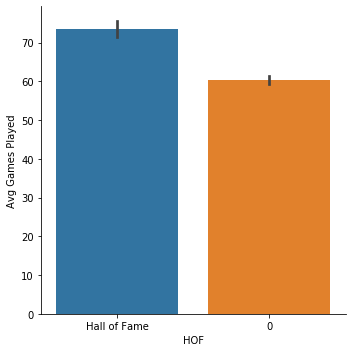

In [22]:
sns.catplot(x="HOF", y="Avg Games Played", data=df_eligible, kind='bar');

Avg height by position

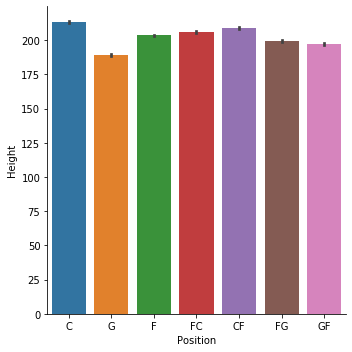

In [23]:
sns.catplot(x="Position", y="Height", data=df_eligible, kind='bar');

What Position gets voted to the HOF more?

In [24]:
df_HOF= df_eligible[df_eligible['HOF']=='Hall of Fame']

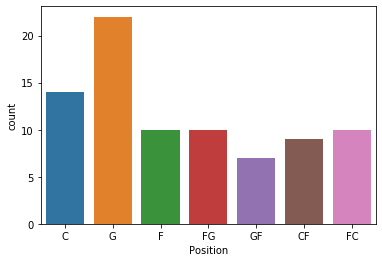

In [25]:
sns.countplot(x="Position", data= df_HOF);

Average Tenure of a HOF

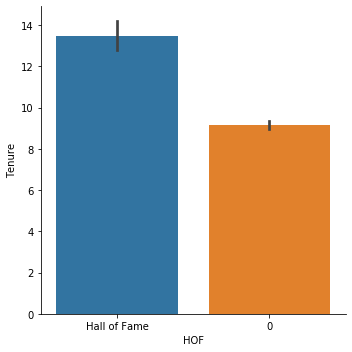

In [26]:
sns.catplot(x="HOF", y="Tenure", data=df_eligible, kind='bar');

In [27]:
df_eligible['is_guard'] = df_eligible.Position.map(lambda x: 'G' in x)
df_eligible['is_forward'] = df_eligible.Position.map(lambda x: 'F' in x)
df_eligible['is_center'] = df_eligible.Position.map(lambda x: 'C' in x)
df_eligible['is_hybrid'] = df_eligible.Position.map(lambda x: len(x) > 1)

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [28]:
df_eligible

Player                       Link  StartYear  EndYear  \
1        Kareem Abdul-Jabbar  /players/a/abdulka01.html       1970     1989   
2         Mahmoud Abdul-Rauf  /players/a/abdulma02.html       1991     2001   
3          Tariq Abdul-Wahad  /players/a/abdulta01.html       1998     2003   
4        Shareef Abdur-Rahim  /players/a/abdursh01.html       1997     2008   
5                 Mark Acres  /players/a/acresma01.html       1988     1993   
6                Alvan Adams  /players/a/adamsal01.html       1976     1988   
7                  Don Adams  /players/a/adamsdo01.html       1971     1977   
8              Michael Adams  /players/a/adamsmi01.html       1986     1996   
9             Rafael Addison  /players/a/addisra01.html       1987     1997   
11              Mark Aguirre  /players/a/aguirma01.html       1982     1994   
12               Danny Ainge  /players/a/aingeda01.html       1982     1995   
13            Cory Alexander  /players/a/alexaco01.html       1996     2005   
14          Victor Alexander  /players/a/alexavi01.html       1992     2002   
16               Malik Allen  /players/a/allenma01.html       2002     2011   
17                 Ray Allen  /players/a/allenra02.html       1997     2014   
18              Rafer Alston  /players/a/alstora01.html       2000     2010   
19              John Amaechi  /players/a/amaecjo01.html       1996     2003   
20              Lou Amundson  /players/a/amundlo01.html       2007     2016   
21            Derek Anderson  /players/a/anderde01.html       1998     2008   
22             Greg Anderson  /players/a/andergr01.html       1988     1998   
23            James Anderson  /players/a/anderja01.html       2011     2016   
24            Kenny Anderson  /players/a/anderke01.html       1992     2005   
25             Nick Anderson  /players/a/anderni01.html       1990     2002   
26          Richard Anderson  /players/a/anderri01.html       1983     1990   
27              Ron Anderson  /players/a/anderro01.html       1985     1994   
28          Shandon Anderson  /players/a/andersh01.html       1997     2006   
29           Willie Anderson  /players/a/anderwi01.html       1989     1997   
30              Greg Anthony  /players/a/anthogr01.html       1992     2002   
31            Tiny Archibald  /players/a/architi01.html       1971     1984   
32                   Jim Ard    /players/a/ardji01.html       1971     1978   
33            Gilbert Arenas  /players/a/arenagi01.html       2002     2012   
35            B.J. Armstrong  /players/a/armstbj01.html       1990     2000   
36         Darrell Armstrong  /players/a/armstda01.html       1995     2008   
37          Hilton Armstrong  /players/a/armsthi01.html       2007     2014   
38             Carlos Arroyo  /players/a/arroyca01.html       2002     2011   
39             Vincent Askew  /players/a/askewvi01.html       1988     1998   
40              Keith Askins  /players/a/askinke01.html       1991     1999   
41             Chucky Atkins  /players/a/atkinch01.html       2000     2010   
43             Stacey Augmon  /players/a/augmost01.html       1992     2006   
44              Isaac Austin  /players/a/austiis01.html       1992     2002   
45             Anthony Avent  /players/a/aventan01.html       1993     2000   
46             Dennis Awtrey  /players/a/awtrede01.html       1971     1982   
47                Jeff Ayres  /players/p/pendeje02.html       2010     2016   
48          Kelenna Azubuike  /players/a/azubuke01.html       2007     2012   
49               John Bagley  /players/b/baglejo01.html       1983     1994   
50                Gus Bailey  /players/b/bailegu01.html       1975     1980   
51              James Bailey  /players/b/baileja01.html       1980     1988   
52              Thurl Bailey  /players/b/baileth01.html       1984     1999   
53                 Vin Baker  /players/b/bakervi01.html       1994     2006   
54           Renaldo Balkman  /players/b/balkmre01.html       2007     2

In [29]:
df_eligible.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 1456
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            1218 non-null   object 
 1   Link              1218 non-null   object 
 2   StartYear         1218 non-null   int64  
 3   EndYear           1218 non-null   int64  
 4   Position          1218 non-null   object 
 5   Tenure            1218 non-null   int64  
 6   Height            1218 non-null   int64  
 7   Weight            1218 non-null   int64  
 8   Birthday          1218 non-null   object 
 9   All_Star_apps     1218 non-null   int64  
 10  All_NBA_apps      1218 non-null   int64  
 11  All_Def_apps      1218 non-null   int64  
 12  HOF               1218 non-null   object 
 13  Games             1218 non-null   int64  
 14  PPG               1218 non-null   float64
 15  TRPG              1218 non-null   float64
 16  APG               1218 non-null   float64


In [30]:
df_eligible['3_pt_pct'] = df_eligible['3_pt_pct'].replace('-', np.nan)

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
df_eligible.All_Star_apps = df_eligible.All_Star_apps.astype('int64')
df_eligible.All_NBA_apps = df_eligible.All_NBA_apps.astype('int64')
df_eligible.All_Def_apps = df_eligible.All_Def_apps.astype('int64')
df_eligible.PPG = df_eligible.PPG.astype('float64')
df_eligible.TRPG = df_eligible.TRPG.astype('float64')
df_eligible.APG = df_eligible.APG.astype('float64')
df_eligible.FG_pct = df_eligible.FG_pct.astype('float64')
df_eligible['3_pt_pct'] = df_eligible['3_pt_pct'].astype('float64')
df_eligible.FT_pct = df_eligible.FT_pct.astype('float64')
df_eligible.eFG_pct = df_eligible.eFG_pct.astype('float64')
df_eligible.PER = df_eligible.PER.astype('float64')
df_eligible.WS = df_eligible.WS.astype('float64')

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
df_eligible.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 1 to 1456
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            1218 non-null   object 
 1   Link              1218 non-null   object 
 2   StartYear         1218 non-null   int64  
 3   EndYear           1218 non-null   int64  
 4   Position          1218 non-null   object 
 5   Tenure            1218 non-null   int64  
 6   Height            1218 non-null   int64  
 7   Weight            1218 non-null   int64  
 8   Birthday          1218 non-null   object 
 9   All_Star_apps     1218 non-null   int64  
 10  All_NBA_apps      1218 non-null   int64  
 11  All_Def_apps      1218 non-null   int64  
 12  HOF               1218 non-null   object 
 13  Games             1218 non-null   int64  
 14  PPG               1218 non-null   float64
 15  TRPG              1218 non-null   float64
 16  APG               1218 non-null   float64


In [33]:
df_eligible.Position.value_counts()

G     381
F     259
FC    169
C     135
GF    112
CF     82
FG     80
Name: Position, dtype: int64

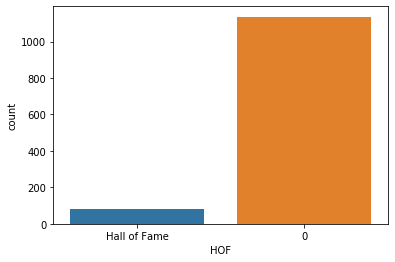

In [34]:
sns.countplot(df_eligible.HOF)

In [35]:
df_eligible.HOF.value_counts()

0               1136
Hall of Fame      82
Name: HOF, dtype: int64

In [36]:
df_eligible.columns

Index(['Player', 'Link', 'StartYear', 'EndYear', 'Position', 'Tenure',
       'Height', 'Weight', 'Birthday', 'All_Star_apps', 'All_NBA_apps',
       'All_Def_apps', 'HOF', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct',
       '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS', 'Avg Games Played',
       'is_guard', 'is_forward', 'is_center', 'is_hybrid'],
      dtype='object')

In [52]:
X = df_eligible[['Tenure', 'Height', 'Weight', 'All_Star_apps', 'All_NBA_apps', 'All_Def_apps', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct', '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS', 'Avg Games Played', 'is_guard', 'is_forward', 'is_center', 'is_hybrid']]
y = df_eligible.HOF
y = y.replace('Hall of Fame', 1)
y = y.astype('int64')

In [53]:
X['Total_points'] = X.PPG * X.Games

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
X = X.fillna(0)

In [55]:
y.sum()

82

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [69]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
y_train_preds_knn = knn.predict(X_train)
f1_train_knn = f1_score(y_train,y_train_preds_knn)
y_preds_knn = knn.predict(X_test)
f1_test_knn = f1_score(y_test, y_preds_knn)
print(f1_train_knn, f1_test_knn)

0.7884615384615385 0.6875


In [75]:
logreg = LogisticRegression(class_weight = 'balanced', random_state = 1, n_jobs = -1)
logreg.fit(X_train, y_train)
y_train_preds_logreg = logreg.predict(X_train)
f1_train_logreg = f1_score(y_train, y_train_preds_logreg)
y_preds_logreg = logreg.predict(X_test)
f1_test_logreg = f1_score(y_test, y_preds_logreg)
print(f1_train_logreg, f1_test_logreg)

0.7453416149068324 0.6296296296296297


In [77]:
tree = DecisionTreeClassifier(random_state = 1, class_weight = 'balanced')
tree.fit(X_train, y_train)
y_train_preds_tree = tree.predict(X_train)
f1_train_tree = f1_score(y_train, y_train_preds_tree)
y_preds_tree = tree.predict(X_test)
f1_test_tree = f1_score(y_test, y_preds_tree)
print(f1_train_tree, f1_test_tree)

1.0 0.7500000000000001


In [79]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 1, class_weight = 'balanced')
rf.fit(X_train, y_train)
y_train_preds_rf = rf.predict(X_train)
f1_train_rf = f1_score(y_train, y_train_preds_rf)
y_preds_rf = rf.predict(X_test)
f1_test_rf = f1_score(y_test, y_preds_rf)
print(f1_train_rf, f1_test_rf)

1.0 0.742857142857143


In [ ]:
#xgboost or voting classifier?